<a id='top'></a>

## Jupyter notebook used in the paper:  
## Aeolian dune modelling from airborne LiDAR, terrestrial LiDAR and Structure from Motion--Multi View Stereo   
by Carlos H. Grohmann et al - 2019/2020  
guano (at) usp (dot) br  
[Institute of Energy and Environment](http://www.iee.usp.br/) - [University of Sao Paulo](https://www5.usp.br/#english) (IEE-USP)  
Spatial Analysis and Modelling Lab - [SPAMLab](https://spamlab.github.io/)

Please check the GitHub repo for the final reference to the paper ([here](https://github.com/CarlosGrohmann/scripts_papers/tree/master/garopaba_als_sfm_tls))  

Shapefiles provided with this script:  
- mask_sfm - mask for ALS and SfM interpolation and comparison  
- mask_volume - mask for volume calculation (ALS and SfM)  
- area_als_dunes - mask for the entire dunefield (ALS coverage)  
- mask_tls - mask of TLS survey area  
- mask_tls_sfm - mask used to constrain random points (TLS x SfM)  
- crests_als_2010 - crestlines of 2010 (ALS)  
- crests_sfm_2019 - crestlines of 2019 (SfM)  
- displacement_crests_2010_2019 - lines connecting 2010 and 2019 crests  
- dgps_garopaba - dgps GCPs  

Point cloud data used in this paper is available via OpenTopography  
- Airborne LiDAR (2010) - http://dx.doi.org/10.5069/G9DN430Z  
- SfM-MVS (2019) - http://dx.doi.org/10.5069/G9DV1H19  
- Terrestrial LiDAR (2019) - https://doi.org/10.5069/G9CN7228  

Notes:  
This is the full research script, meaning some of the stuff here was not used in the final paper, like r3.volume and the normality tests of displacement length  

This notebook uses f-strings - needs python 3.6+  

Since we use python 3, we need GRASS-GIS 7.8+  

The external file 'azim_p3.py' has the function to calculate azimuth and length of lines  

My GRASS wasn't working witb LibLAS for direct LAS import, so I converted it to TXT. Depending on the GRASS installation, you can use v.in.lidar or v.in.pdal as well

### Quick links to notebook sections   
- **[Imports and auxiliar functions](#Imports-and-auxiliar-functions)**  
 - [GRASS setup](#GRASS-setup)  
 - [Data directory](#Data-directory)  
<br>
- **[Data Import](#Data-Import)**  
 - [Vector masks - ALS](#ALS-mask)  
 - [Vector masks - TLS](#TLS-mask)  
 - [Vector masks - SfM](#SfM-mask)  
 - [Vector masks - SfM+TLS](#SfM-+-TLS-mask)  
 - [Volume mask](#Volume-mask)
 - [Import masks](#Import-masks)  
 - [Airborne LiDAR data](#Airborne-LiDAR-data)
 - [SfM-MVS reconstruction of dune field](#SfM-MVS-reconstruction-of-dune-field)
   - [Full-resolution point cloud (for comparison with TLS)](#Full-resolution-point-cloud-%28for-comparison-with-TLS%29)
   - [Thinned point cloud (for comparison with ALS)](#Thinned-point-cloud-%28for-comparison-with-ALS%29)
 - [Terrestrial LiDAR](#Terrestrial-LiDAR)  
<br>
- **[Maps of point density](#Maps-of-point-density)**  
  - [Airborne LiDAR density](#Airborne-LiDAR-density)
  - [SfM - full resolution (TLS area) density](#SfM-%2D-full-resolution-%28TLS-area%29-density)
  - [SfM - thinned by 125th points (TLS area) density](#SfM-%2D-thinned-by-125th-points-%28TLS-area%29-density)
  - [Terrestrial LiDAR density](#Terrestrial-LiDAR-density)  
<br>
- **[TLS scans positions](#TLS-scans-positions)**  
<br>
- **[Comparison between  Terrestrial LiDAR / SfM-MVS](#Comparison-between-Terrestrial-LiDAR-/-SfM-MVS)**
 - [Interpolate TLS and SfM DEMs, create shaded relief images](#Interpolate-TLS-and-SfM-DEMs,-create-shaded-relief-images)
 - [Surface roughness](#Surface-roughness)  
 
 - [Noise reduction](#Noise-reduction)  
 
 - [Stats, metrics (SfM x TLS)](#Stats,-metrics-%28SfM-x-TLS%29)
 
 - [Stats - all pixels](#Stats---all-pixels)

 - [Graphics, errors (all pixels)](#Graphics,-errors-%28all-pixels%29)

 - [Correlation (all pixels)](#Correlation-%28all-pixels%29)

 - [MAE, RMSE (all pixels)](#MAE,-RMSE-%28all-pixels%29)
 
 - [Stats - random selection within dataframe](#Stats---random-selection-within-dataframe)  
 
  - [Graphics, errors (2000 pixels)](#Graphics,-errors-%282000-pixels%29)  

 - [Correlation (2000 pixels)](#Correlation-%282000-pixels%29)  

 - [MAE, RMSE (2000 pixels)](#MAE,-RMSE-%282000-pixels%29)  
<br>
- **[Comparison between Airborne LiDAR / SfM-MVS](#Comparison-between-Airborne-LiDAR-/-SfM-MVS)**

 - [Interpolate ALS and SfM DEMs, create shaded relief images](#Interpolate-ALS-and-SfM-DEMs,-create-shaded-relief-images)

 - [Stats, histograms](#Stats,-histograms)

 - [Volume calculation with r.volume and r3.stats](#Volume-calculation-with-r.volume-and-r3.stats)

 - [Displacement of dune crests](#Displacement-of-dune-crests)

 - [Azimuth analysis](#Azimuth-analysis)

 - [Topographic profiles](#Topographic-profiles)




<br><br><br><br><br><br>
<div style="text-align: right"><a href="#top">back to top</a></div>

## Imports and auxiliar functions.

In [1]:
# import python libraries
import sys, os, itertools
import numpy as np
import scipy.stats as ss
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import seaborn as sns
import rasterio as rio
# import rasterio.mask as riom
import xarray as xr
# import fiona as fna
# import geopandas as gpd
import subprocess
from IPython.display import Image # can use this to display GRASS maps
# stats
from statsmodels.graphics.gofplots import qqplot
from scipy.stats import linregress

In [2]:
# import module to calculate azimuth of lines -- requires python GDAL/OGR libraries 
# mac fix (gdal+pyenv): # https://gist.github.com/cspanring/5680334#gistcomment-2898629

# on Linux, I needed to set this or jupyter wouldn't find the ogr module:
if sys.platform == "linux" or sys.platform == "linux2":
    sys.path.append('/usr/lib/python3/dist-packages') 
import azim_p3

In [3]:
# helper func: round to nearest 5
def round5(x):
    rounded = int(round(x/5.0)*5.0)
    return rounded

In [4]:
# error measurements
def err_mse(x1, x2, axis=0):
    """mean squared error"""
    x1 = np.asanyarray(x1)
    x2 = np.asanyarray(x2)
    return np.mean((x1-x2)**2, axis=axis)

def err_rmse(x1, x2, axis=0):
    """root mean squared error"""
    x1 = np.asanyarray(x1)
    x2 = np.asanyarray(x2)
    return np.sqrt(err_mse(x1, x2, axis=axis))

def err_mae(x1, x2, axis=0):
    """mean absolute error"""
    x1 = np.asanyarray(x1)
    x2 = np.asanyarray(x2)
    return np.mean(np.abs(x1-x2), axis=axis)

In [5]:
def fdr(df):
    ''' Freedman–Diaconis rule to calculate optimal bin size of histograms
    '''
    q25 = df.quantile(0.25)
    q75 = df.quantile(0.75)
    len_max = df.max()
    len_min = df.min()
    len_n = len(df)
    IQR = q75 - q25
    bin_width = 2. * IQR * (len_n)**(-1./3.)
    nbins = (len_max - len_min)/bin_width
    return int(nbins)

In [6]:
# aux func
def raster_as_array(raster):
    ''' return GRASS raster as numpy array - remove null values '''
    grass.run_command('g.region', raster=raster, flags='a')
    raster_array = garray.array()
    raster_array.read(raster, null=np.nan)
    raster_array_flat = raster_array.flatten(order='C')
    raster_1d = raster_array_flat[~np.isnan(raster_array_flat)]
    return raster_1d

In [7]:
# matplotlib figures appear inline in the notebook rather than in a new window.
%matplotlib inline

<br><br>
<div style="text-align: right"><a href="#top">back to top</a></div>

## GRASS setup

This notebook was made for a Linux machine, since there are still some issues with GRASS 7.8+ on MacOS. I left an example in the cell below of how I was using it with two systems, using sys.platform

In [8]:
# If you use two systems this makes things a bit easier
# I had this for setting up gisbase, rcfile and dataDir

# if sys.platform == "linux" or sys.platform == "linux2":
#     rcfile = gsetup.init(gisbase, "/mnt/sda/grassdata/", "utm", "garopaba_22J")
# elif sys.platform == "darwin":
#     rcfile = gsetup.init(gisbase, "/Volumes/MacintoshHD2/grassdata/", "utm", "garopaba_22J")
# elif platform == 

In [9]:
# requires version 7.8+
# create GRASS GIS runtime environment (mac and linux)
gisbase = subprocess.check_output(["grass79", "--config", "path"]).strip().decode()

os.environ['GISBASE'] = gisbase
sys.path.append(os.path.join(gisbase, "etc", "python"))

# GRASS GIS imports
import grass.script as grass
import grass.script.setup as gsetup
import grass.script.array as garray
import grass.script.vector as gvect

# check GRASS version
# print(gisbase)

In [10]:
# set GRASS GIS session data
if sys.platform == "linux" or sys.platform == "linux2":
    rcfile = gsetup.init(gisbase, "/mnt/sda/grassdata/", "utm", "garopaba_22J")
elif sys.platform == "darwin":
    rcfile = gsetup.init(gisbase, "/Volumes/MacintoshHD2/grassdata/", "utm", "garopaba_22J")
    
# grass.message('Current GRASS GIS 7 environment:')
print (grass.gisenv())

{'GISDBASE': '/Volumes/MacintoshHD2/grassdata/', 'LOCATION_NAME': 'utm', 'MAPSET': 'garopaba_22J'}


In [11]:
# overwrite for GRASS modules
ow = True

In [12]:
# check region
# grass.parse_command('g.region', flags='pg')
# grass.run_command('g.region', flags='pg')

<br><br>
<div style="text-align: right"><a href="#top">back to top</a></div>

## Data directory

In [13]:
# Data dir 
if sys.platform == "linux" or sys.platform == "linux2":
    dataDir = '/mnt/sda/Dropbox/USP/projetosPesquisa/LiDAR_terrestre_SfM/_areas_estudo/garopaba/DEMs_shapes'
elif sys.platform == "darwin":
    dataDir = '/Volumes/MacintoshHD2/Dropbox/USP/projetosPesquisa/LiDAR_terrestre_SfM/_areas_estudo/garopaba/DEMs_shapes'

    
# point clouds dir 
if sys.platform == "linux" or sys.platform == "linux2":
    pcDir = '/mnt/sda/geodata/pcs_garopaba'
elif sys.platform == "darwin":
    pcDir = '/Volumes/MacintoshHD2/_geodata/_dados_SPAMLab/garopaba/pcs_garopaba'


<br><br><br>
<div style="text-align: right"><a href="#top">back to top</a></div>

## Data Import

### Vector masks

#### ALS mask  

In [14]:
# Entire dune field (polygon, manually digitized)
shp_als_mask = f'{dataDir}/mask_als_dunes.shp'
mask_als = 'mask_als'

#### TLS mask

In [15]:
# Dune field TLS area mask (polygon, manually digitized)
# import points in GRASS with r.in.xyz with 1m resolution, export as tiff, draw polygon in QGIS:
# g.region -pa res=01 w=732187 e=732674 n=6900302 s=6899889
# r.in.xyz --overwrite input=pcloud_tls_20mm.txt output=mdt_tls_2019 method=mean separator=comma
# r.out.gdal --overwrite input=mdt_tls_2019@garopaba_22J output=pcloud_1m.tif format=GTiff
shp_tls_mask = f'{dataDir}/mask_tls.shp'
mask_tls = 'mask_tls'

#### SfM mask

In [16]:
# Dune field area mask (polygon, manually digitized)
shp_sfm_mask = f'{dataDir}/mask_sfm.shp'
mask_sfm = 'mask_sfm' # mask for clipping (pretty much the whole SfM area)

#### SfM + TLS mask

In [17]:
# import mask to constrain random points 
# (excludes) vegetations and areas without TLS data
shp_tls_sfm = f'{dataDir}/mask_tls_sfm.shp'
mask_tls_sfm = 'mask_tls_sfm'

#### Volume mask

In [18]:
# area for volume calculation
shp_vol_mask = f'{dataDir}/mask_volume.shp'
mask_vol = 'mask_vol'

#### Import masks

In [19]:
grass.run_command('v.in.ogr', input=shp_als_mask, output=mask_als, flags='o', overwrite=ow)

In [20]:
grass.run_command('v.in.ogr', input=shp_tls_mask, output=mask_tls, flags='o', overwrite=ow)

In [21]:
grass.run_command('v.in.ogr', input=shp_sfm_mask, output=mask_sfm, flags='o', overwrite=ow)

In [22]:
grass.run_command('v.in.ogr', input=shp_tls_sfm, output=mask_tls_sfm, flags='o', overwrite=ow)

In [23]:
grass.run_command('v.in.ogr', input=shp_vol_mask, output=mask_vol, flags='o', overwrite=ow)

<br>
<div style="text-align: right"><a href="#top">back to top</a></div>

### Airborne LiDAR data

Airborne LiDAR survey (2010-09, processed by Geoid ltda.)  
This dataset is available via OpenTopography - http://dx.doi.org/10.5069/G9DN430Z  

- Delivered in LAS format
- full point cloud: 12,319,797 points (area larger than dune field)  
<br>
- first return points extract with LAStools  
- first-return point cloud: 11,574,555 points (area larger than dune field)  
<br>
- imported into GRASS as vector points 
- clipped to a vector mask (commom area of SfM-MVS and ALS)
- resulting vector (pcloud_als): 2,380,005 points

In [24]:
# convert LAS to TXT (run this in a terminal):
# cd _path_to_your_files_
# using Martin Isenburg's LAStools with wine:
# wine _path_to_lastools_bin_/las2txt.exe -i Pontos_Garopaba.las -parse xyz -rescale 0.01 0.01 0.01 -first_only -o pcloud_als.txt

In [25]:
# ALS - names and files
pc_als_orig = 'pc_als_2010_orig'
pc_als = 'pc_als'
pc_als_txt = f'{pcDir}/pcloud_als.txt' 

In [26]:
# import ALS data, clip to mask and remove original
grass.run_command('g.region', vector=mask_als, res=0.1, flags='pa')
grass.run_command('v.in.ascii', input=pc_als_txt, output=pc_als_orig, separator='space', x=1, y=2, z=3, flags='ztr', overwrite=ow) 
grass.run_command('v.clip', input=pc_als_orig, output=pc_als, clip=mask_sfm, overwrite=ow) # points: 2,380,005
grass.run_command('g.remove', type='vector', name=pc_als_orig, flags='f')

<br>
<div style="text-align: right"><a href="#top">back to top</a></div>

### SfM-MVS reconstruction of dune field

SfM-MVS survey 2019-02  
This dataset is available via OpenTopography - http://dx.doi.org/10.5069/G9DV1H19

- Exported from Agisoft Metashape as LAS  
- Converted to TXT with LAStools     
- full point cloud: 344,595,132 points  
<br>

**For comparison with TLS:**
- imported into GRASS as mean value in each 10cm-pixel raster (r.in.xyz)  
- clipped to a vector mask (TLS survey area)  
- converted to vector for interpolation  
- resulting vector (pc_sfm_rinxyz_avg10cm): 8,079,569 points  
<br>

**For comparison with ALS:**
- thinned by every 125th point to be of similar size of the ALS point cloud after clipping
- imported into GRASS as vector points 
- clipped to a vector mask (commom area of SfM-MVS and ALS)  
- resulting vector (pc_sfm_t125): 2,378,399 points  

#### Full-resolution point cloud (for comparison with TLS)

In [27]:
# convert LAS to TXT (run this in a terminal):
# cd _path_to_your_files_
# LAStools:
# wine _path_to_lastools_bin_/las2txt.exe -i pcloud_sfm.las -parse xyz -rescale 0.001 0.001 0.001 -o pcloud_sfm_full.txt

In [28]:
# SfM - names and files
sfm_avg10cm = 'sfm_rinxyz_avg10cm'
pc_sfm_avg10cm = 'pc_sfm_rinxyz_avg10cm'
pc_sfm_tlsarea = f'{pcDir}/pcloud_sfm_full.txt' 

In [29]:
# set region and mask
grass.run_command('g.region', vector=mask_tls, res=0.1, flags='pa')
grass.run_command('r.mask', vector=mask_tls, overwrite=ow)

In [30]:
# import as raster using 'mean' val in 10cm, fix null values
grass.run_command('r.in.xyz', input=pc_sfm_tlsarea, output=sfm_avg10cm, method='mean', separator='space', overwrite=ow) 
grass.run_command('r.null', map=sfm_avg10cm, setnull=0)

In [31]:
# convert to vector for interpolation
grass.run_command('r.to.vect', input=sfm_avg10cm, output=pc_sfm_avg10cm, type='point', flags='zt')
# grass.parse_command('v.info', map=sfm_mean)
# Number of points:       8,079,569

#### Thinned point cloud (for comparison with ALS)

In [32]:
# convert LAS to TXT and thin points (run this in a terminal):
# cd _path_to_your_files_
# LAStools:
# wine _path_to_lastools_bin_/las2txt.exe -i pcloud_sfm.las -parse xyz -rescale 0.001 0.001 0.001 -keep_every_nth 125 -o pcloud_sfm_full_t125.txt

In [33]:
# SfM - names and files
pc_sfm_t125_orig = 'pc_sfm_t125_orig'
pc_sfm_t125 = 'pc_sfm_t125'
pc_sfm_t125_txt = f'{pcDir}/pcloud_sfm_t125.txt' 

In [34]:
# import SfM data (thinned), clip to SfM mask and remove original vector
grass.run_command('g.region', vector=mask_sfm, res=0.1, flags='pa')
grass.run_command('v.in.ascii', input=pc_sfm_t125_txt, output=pc_sfm_t125_orig, separator='space', x=1, y=2, z=3, flags='ztr', overwrite=ow)
grass.run_command('v.clip', input=pc_sfm_t125_orig, output=pc_sfm_t125, clip=mask_sfm, overwrite=ow) # points: 2,378,399
grass.run_command('g.remove', type='vector', name=pc_sfm_t125_orig, flags='f')

<br>
<div style="text-align: right"><a href="#top">back to top</a></div>

### Terrestrial LiDAR

TLS survey 2019-02  
This dataset is available via OpenTopography - https://doi.org/10.5069/G9CN7228  

- Exported from FARO Scene as E57  
- Converted to TXT with CloudCompare (in Windows, because E57 doesn't really work in other OS)   
- Thinned in FARO Scene with 20mm minimum distance between points  
- full point cloud: 170,141,709 points  
<br>
- imported into GRASS as mean value in each 10cm-pixel raster (r.in.xyz)  
- clipped to a vector mask (TLS survey area)  
- converted to vector for interpolation
- resulting vector (pc_tls_rinxyz_avg10cm): 7,039,501 points

In [35]:
# TLS - names and files
tls_avg10cm = 'tls_rinxyz_avg10cm'
pc_tls_avg10cm = 'pc_tls_rinxyz_avg10cm'
pc_tls_txt = f'{pcDir}/pcloud_tls_20mm_utm.txt' #adjust to yours

In [36]:
# set region and mask
grass.run_command('g.region', vector=mask_tls, res=0.1, flags='pa')
grass.run_command('r.mask', vector=mask_tls, overwrite=ow)

In [37]:
# import as raster using 'mean' val in 10cm, fix null values
grass.run_command('r.in.xyz', input=pc_tls_txt, output=tls_avg10cm, method='mean', separator='comma', overwrite=ow) 
grass.run_command('r.null', map=tls_avg10cm, setnull=0)

In [38]:
# convert to vector for interpolation
grass.run_command('r.to.vect', input=tls_avg10cm, output=pc_tls_avg10cm, type='point', flags='zt', overwrite=ow)
# grass.parse_command('v.info', map=tls_mean)
# Number of points:       7,039,501

<br><br><br>
<div style="text-align: right"><a href="#top">back to top</a></div>

## Maps of point density

Import point clouds as raster to create maps of point density/m2  
See details of each point cloud processing in the folowwing sections

In [39]:
# remove any raster mask
grass.run_command('r.mask', flags='r')

#### Airborne LiDAR density

In [40]:
# ALS
pc_als_txt = f'{pcDir}/pcloud_als.txt'
als_density = 'als_density'
grass.run_command('g.region', vector=mask_als, res=1, grow=10, flags='pa')

In [41]:
grass.run_command('r.in.xyz', input=pc_als_txt, output=als_density, method='n', separator='space', overwrite=ow) 
grass.run_command('r.null', map=als_density, setnull=0)
grass.run_command('r.colors', map=als_density, color='viridis', flags='e')

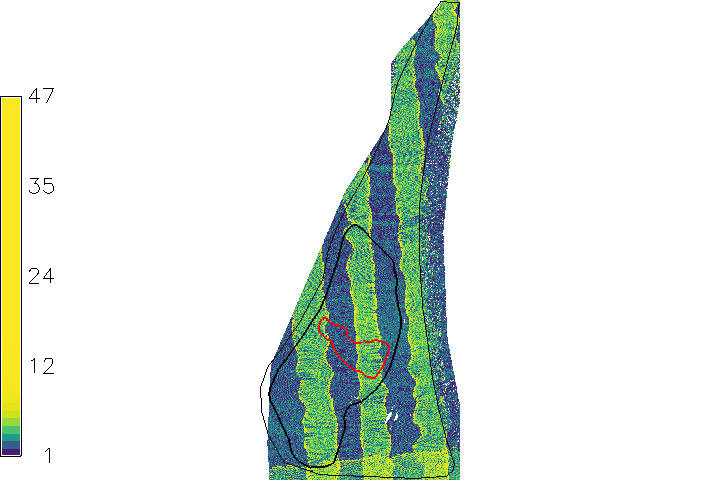

In [43]:
# display with virtual monitor rendered to png
grass.run_command('d.mon', start='png', output='view.png', overwrite=ow)
grass.run_command('d.rast', map=als_density)
grass.run_command('d.vect', map=mask_als, fill_color='none', width=1) # 
grass.run_command('d.vect', map=mask_sfm, fill_color='none', width=2) # SfM area in black
grass.run_command('d.vect', map=mask_tls, fill_color='none', color='red', width=2) # TLS area in red
grass.run_command('d.legend', raster=als_density, at='5,80,0,3', flags='sf')
Image('view.png') 

In [44]:
grass.run_command('d.mon', stop='png') 

#### SfM - full resolution (TLS area)  density

In [45]:
# SfM - full resolution
pc_sfm_tlsarea = f'{pcDir}/pcloud_sfm_full.txt' 
sfm_full_density = 'sfm_tlsarea_fullres_density'
grass.run_command('g.region', vector=mask_tls, res=1, grow=10, flags='pa')

In [46]:
grass.run_command('r.in.xyz', input=pc_sfm_tlsarea, output=sfm_full_density, method='n', separator='space', overwrite=ow)
grass.run_command('r.null', map=sfm_full_density, setnull=0)
grass.run_command('r.colors', map=sfm_full_density, color='viridis', flags='e')

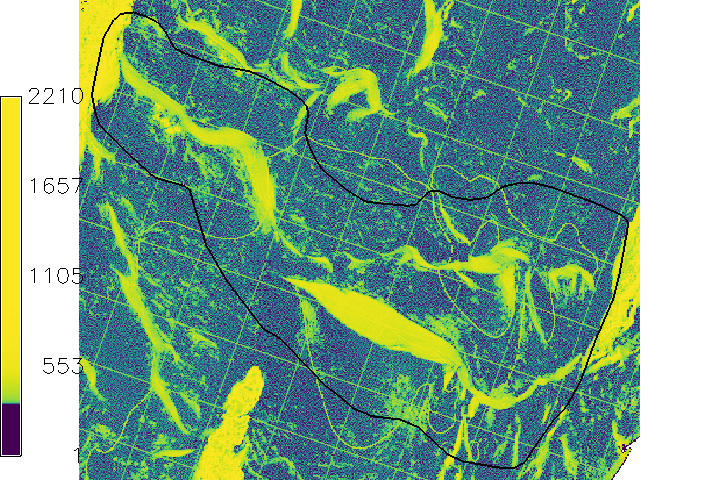

In [47]:
# display with virtual monitor rendered to png
grass.run_command('d.mon', start='png', output='view.png', overwrite=ow)
grass.run_command('d.rast', map=sfm_full_density)
grass.run_command('d.vect', map=mask_tls, fill_color='none', width=2, color='black') # TLS area in black
grass.run_command('d.legend', raster=sfm_full_density, at='5,80,0,3', flags='sf')
Image('view.png') 

In [48]:
grass.run_command('d.mon', stop='png') 

#### SfM - thinned by 125th points (TLS area)  density

In [49]:
# thinned by 125th points
pc_sfm_t125_txt = f'{pcDir}/pcloud_sfm_t125.txt' # adjust to yours
sfm_t125_density = 'sfm_t125_density'
grass.run_command('g.region', vector=mask_tls, res=1, grow=10, flags='pa')

In [50]:
grass.run_command('r.in.xyz', input=pc_sfm_t125_txt, output=sfm_t125_density, method='n', separator='space', overwrite=ow)
grass.run_command('r.null', map=sfm_t125_density, setnull=0)
grass.run_command('r.colors', map=sfm_t125_density, color='viridis', flags='e')

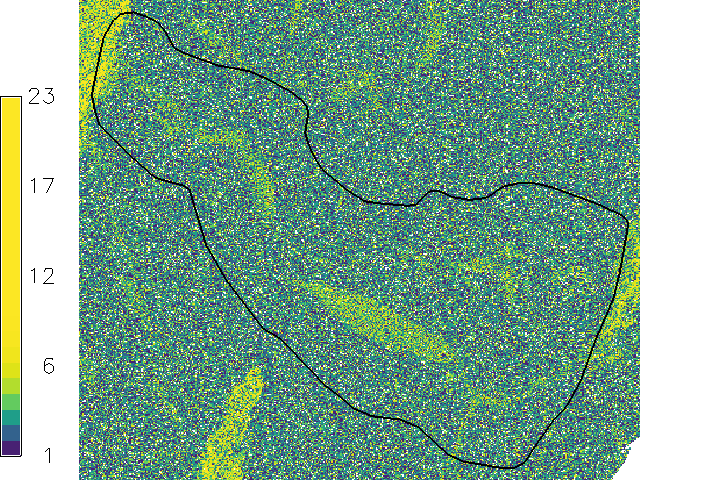

In [51]:
# display with virtual monitor rendered to png
grass.run_command('d.mon', start='png', output='view.png', overwrite=ow)
grass.run_command('d.rast', map=sfm_t125_density)
grass.run_command('d.vect', map=mask_tls, fill_color='none', width=2, color='black') # TLS area in black
grass.run_command('d.legend', raster=sfm_t125_density, at='5,80,0,3', flags='sf')
Image('view.png') 

In [52]:
grass.run_command('d.mon', stop='png') 

#### Terrestrial LiDAR density

In [53]:
# TLS
pc_tls_txt = f'{pcDir}/pcloud_tls_20mm_utm.txt' #adjust to yours
tls_density = 'tls_density'
grass.run_command('g.region', vector=mask_tls, res=1, grow=10, flags='pa')

In [54]:
grass.run_command('r.in.xyz', input=pc_tls_txt, output=tls_density, method='n', separator='comma', overwrite=ow)
grass.run_command('r.null', map=tls_density, setnull=0)
grass.run_command('r.colors', map=tls_density, color='viridis', flags='e')

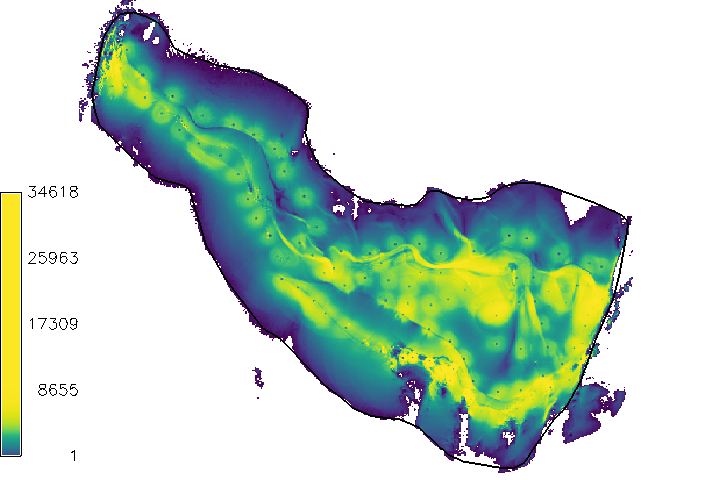

In [55]:
# display with virtual monitor rendered to png
grass.run_command('d.mon', start='png', output='view.png', overwrite=ow)
grass.run_command('d.rast', map=tls_density)
grass.run_command('d.vect', map=mask_tls, fill_color='none', width=2, color='black') # TLS area in black
grass.run_command('d.legend', raster=tls_density, at='5,60,0,3', flags='sf')
Image('view.png') 

In [56]:
grass.run_command('d.mon', stop='png') 

<br><br><br>
<div style="text-align: right"><a href="#top">back to top</a></div>

## TLS scans positions

In [57]:
# import points
shp_scans = f'{dataDir}/scans_position.shp'
scans = 'scans_tls'
grass.run_command('v.in.ogr', input=shp_scans, output=scans, flags='o', overwrite=ow)

In [58]:
# set region
grass.run_command('g.region', vector=mask_tls, res=1, grow=10, flags='pa')

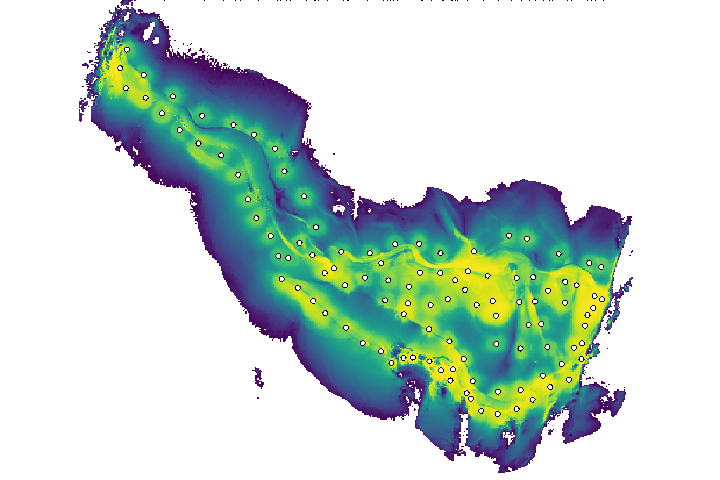

In [59]:
# display with virtual monitor rendered to png
grass.run_command('d.mon', start='png', output='view.png', overwrite=ow)
grass.run_command('d.rast', map=tls_density)
grass.run_command('d.vect', map=scans, fill_color='white', icon='basic/circle') # TLS area in black
Image('view.png') 

In [60]:
grass.run_command('d.mon', stop='png') 

<br><br><br>
<div style="text-align: right"><a href="#top">back to top</a></div>

## Comparison between Terrestrial LiDAR / SfM-MVS

### Interpolate TLS and SfM DEMs, create shaded relief images

In [61]:
# settings for interpolation, shaded reliefs, names for the files
method='bilinear'
step = 0.5
altitude = 30
azimuth = 25
az_txt = f'{azimuth:>03.0f}' #'{:>03.0f}'.format(azimuth)

dem_tls_10cm = f'tls_rinxyz_avg10cm_{method}_step_{str(step)}'
dem_tls_10cm_shade = f'{dem_tls_10cm}_shade_{az_txt}_{str(altitude)}'

dem_sfm_10cm = f'sfm_rinxyz_avg10cm_{method}_step_{str(step)}'
dem_sfm_10cm_shade = f'{dem_sfm_10cm}_shade_{az_txt}_{str(altitude)}'

diff_sfm_tls_10cm = 'diff_10cm_sfm_tls'
diff_sfm_tls_10cm_shade = f'{diff_sfm_tls_10cm}_shade_{az_txt}_{str(altitude)}'

In [62]:
# set region and mask
grass.run_command('g.region', vector=mask_tls, res=0.1, flags='pa')
grass.run_command('r.mask', vector=mask_tls, overwrite=ow)

In [63]:
# interpolate TLS - 10cm
grass.run_command('v.surf.bspline', input=pc_tls_avg10cm, raster_output=dem_tls_10cm, ew_step=step, ns_step=step, method=method, mask='MASK', overwrite=ow)

In [64]:
# interpolate SfM - 10cm
grass.run_command('v.surf.bspline', input=pc_sfm_avg10cm, raster_output=dem_sfm_10cm, ew_step=step, ns_step=step, method=method, mask='MASK', overwrite=ow)

In [65]:
# DEM of Difference - SfM minus TLS
grass.mapcalc('${out} = ${sfm} - ${tls}',
    out=diff_sfm_tls_10cm,
    tls=dem_tls_10cm,
    sfm=dem_sfm_10cm,
    overwrite = True)

In [66]:
# make shaded reliefs and optionally export as tiff
# TLS
grass.run_command('r.relief', input=dem_tls_10cm, output=dem_tls_10cm_shade, azimuth=azimuth, altitude=altitude, overwrite=ow)
# grass.run_command('r.out.gdal', input=dem_tls_shade, output=dem_tls_shade+'.tif', format='GTiff', type='Int16', overwrite=ow)

# SfM
grass.run_command('r.relief', input=dem_sfm_10cm, output=dem_sfm_10cm_shade, azimuth=azimuth, altitude=altitude, overwrite=ow)
# grass.run_command('r.out.gdal', input=dem_sfm_5cm_shade, output=dem_sfm_5cm_shade+'.tif', format='GTiff', type='Int16', overwrite=ow)

# diff 
grass.run_command('r.colors', map=diff_sfm_tls_10cm, color='differences', flags='e')
grass.run_command('r.relief', input=diff_sfm_tls_10cm, output=diff_sfm_tls_10cm_shade, azimuth=azimuth, altitude=altitude, overwrite=ow)
# grass.run_command('r.out.gdal', input=diff_sfm_tls_shade, output=diff_sfm_tls_shade+'.tif', format='GTiff', type='Int16', overwrite=ow)

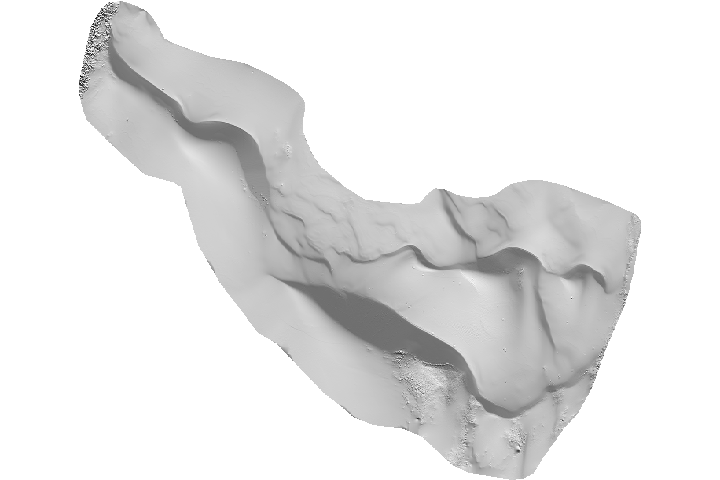

In [67]:
# TLS
# display with virtual monitor rendered to png
grass.run_command('d.mon', start='png', output='view.png', overwrite=ow)
grass.run_command('d.rast', map=dem_tls_10cm_shade)
Image('view.png') 

In [68]:
grass.run_command('d.mon', stop='png') 

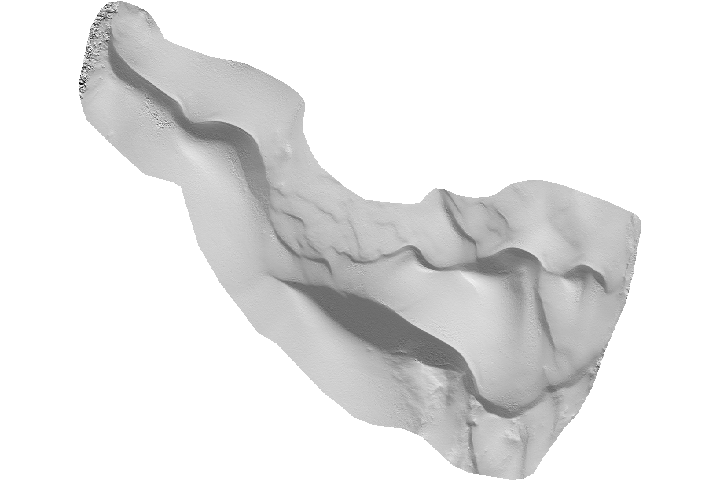

In [69]:
# SfM
# display with virtual monitor rendered to png
grass.run_command('d.mon', start='png', output='view.png', overwrite=ow)
grass.run_command('d.rast', map=dem_sfm_10cm_shade)
Image('view.png') 

In [70]:
grass.run_command('d.mon', stop='png') 

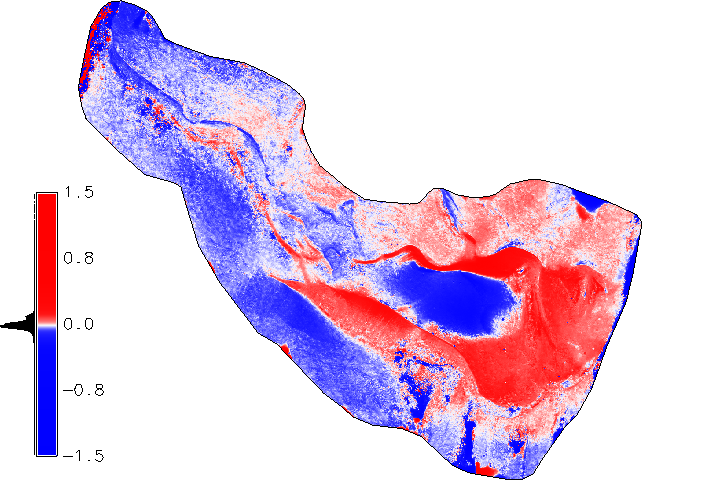

In [71]:
# diff
# display with virtual monitor rendered to png
grass.run_command('d.mon', start='png', output='view.png', overwrite=ow)
grass.run_command('d.rast', map=diff_sfm_tls_10cm)
grass.run_command('d.vect', map=mask_tls, fill_color='none')
grass.run_command('d.legend', raster=diff_sfm_tls_10cm, at='5,60,5,8', range='-1.5,1.5', flags='d')
Image('view.png') 
Image('view.png') 

In [72]:
grass.run_command('d.mon', stop='png') 

<br>
<div style="text-align: right"><a href="#top">back to top</a></div>

### Surface roughness

In [73]:
# set region and mask
mask_tls = 'mask_tls'
grass.run_command('g.region', vector=mask_tls, res=0.1, flags='pa')
grass.run_command('r.mask', vector=mask_tls, overwrite=ow)

In [74]:
# settings for roughness, names for the files
w = 5  # window size
op = 'stddev' # neighborhood operation

tls_slope = dem_tls_10cm + '_slope'
sfm_slope = dem_sfm_10cm + '_slope'

tls_rough = tls_slope + '_std_' + str(w) + 'x' + str(w)
sfm_rough = sfm_slope + '_std_' + str(w) + 'x' + str(w)

In [75]:
# slope
grass.run_command('r.slope.aspect', elevation=dem_tls_10cm, slope=tls_slope, overwrite=ow)
grass.run_command('r.slope.aspect', elevation=dem_sfm_10cm, slope=sfm_slope, overwrite=ow)

In [76]:
# roughness
grass.run_command('r.neighbors', input=tls_slope, output=tls_rough, method=op, size=w, overwrite=ow)
grass.run_command('r.neighbors', input=sfm_slope, output=sfm_rough, method=op, size=w, overwrite=ow)

In [77]:
# set custom colortable, based on viridis
rules='''0 255:255:255
1 253:231:37
3 93:201:98
5 32:144:141
7 58:82:139
9 68:1:84
13 155:0:0
30 155:0:0
'''
# save rules to file
with open('rules.txt', 'w+') as file:
    file.write(rules)

grass.run_command('r.colors', map=tls_rough, rules='rules.txt')
grass.run_command('r.colors', map=sfm_rough, rules='rules.txt')

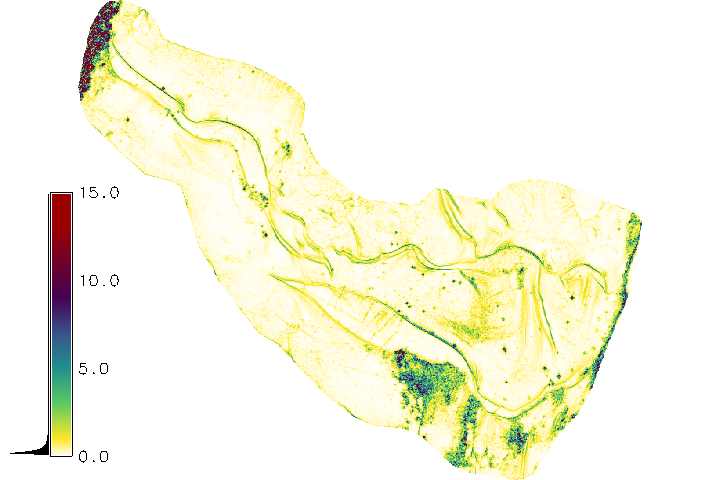

In [78]:
# display with virtual monitor rendered to png
grass.run_command('d.mon', start='png', output='view.png', overwrite=ow)
grass.run_command('d.rast', map=tls_rough)
grass.run_command('d.legend', raster=tls_rough, at='5,60,7,10', range='0,15', flags='sd', label_step=5)
Image('view.png') 

In [79]:
grass.run_command('d.mon', stop='png') 

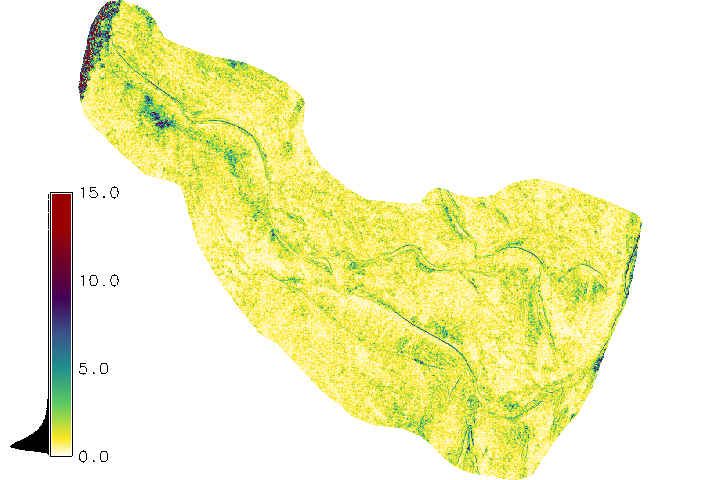

In [80]:
# display with virtual monitor rendered to png
grass.run_command('d.mon', start='png', output='view.png', overwrite=ow)
grass.run_command('d.rast', map=sfm_rough)
grass.run_command('d.legend', raster=sfm_rough, at='5,60,7,10', range='0,15', flags='sd', label_step=5)
Image('view.png') 

In [81]:
grass.run_command('d.mon', stop='png') 

<br>
<div style="text-align: right"><a href="#top">back to top</a></div>

### Noise reduction
Denoise analysis is in notebook  *garopaba_als_sfm_tls_denoise_jupyter_python3.ipynb*  
- FPDEMS algorithm
- tested different parameters combinations
- run FPD for SfM-MVS DEM (TLS area)
- imported FPD DEM bck to GRASS for comparison with TLS

<br>
<div style="text-align: right"><a href="#top">back to top</a></div>

### Stats, metrics (SfM x TLS)

##### run stats and error metrics only for a sub-mask covering the areas without vegetation or interpolated voids in TLS

In [84]:
# make new raster of diff only inside the inner mask, for legend display
grass.run_command('r.mask', vector=mask_tls_sfm, overwrite=ow)
diff_sfm_tls_10cm_clip = f'{diff_sfm_tls_10cm}_clip'
grass.mapcalc('${out} = if(${dem},${dem},null())',
    out=diff_sfm_tls_10cm_clip,
    dem=diff_sfm_tls_10cm,
    overwrite = True)
grass.run_command('r.colors', map=diff_sfm_tls_10cm_clip, color='differences')
grass.run_command('r.mask', flags='r')

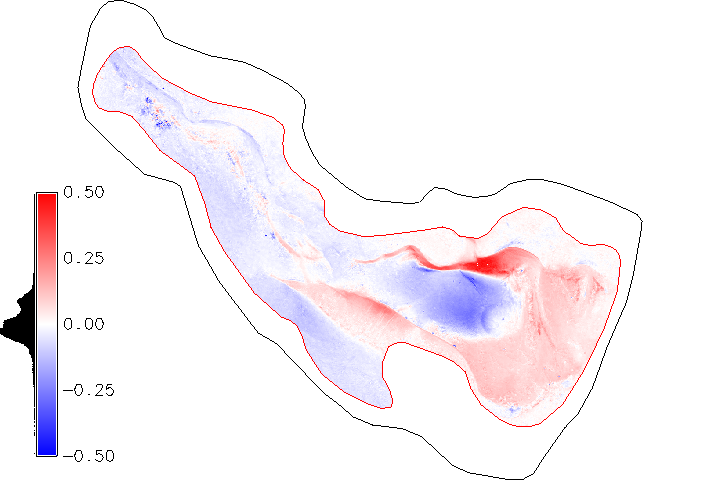

In [87]:
# display with virtual monitor rendered to png
grass.run_command('d.mon', start='png', output='view.png', overwrite=ow)
grass.run_command('d.rast', map=dem_tls_10cm_shade)
grass.run_command('d.rast', map=diff_sfm_tls_10cm_clip)
grass.run_command('d.vect', map=mask_tls, fill_color='none')
grass.run_command('d.vect', map=mask_tls_sfm, fill_color='none', color='red') # mask for error analysis
grass.run_command('d.legend', raster=diff_sfm_tls_10cm_clip, at='5,60,5,8', range='-0.5,1', flags='d')
Image('view.png') 

In [88]:
grass.run_command('d.mon', stop='png') 

In [89]:
# set display format for stats
pd.set_option('display.float_format', lambda x: '%.3f' % x)

<br>
<div style="text-align: right"><a href="#top">back to top</a></div>

#### Export DEMs (inside mask) as tiff - faster to read into pandas with rasterio

In [90]:
# set region and mask
mask_tls_sfm = 'mask_tls_sfm'
grass.run_command('g.region', vector=mask_tls_sfm, res=0.1, flags='pa')
grass.run_command('r.mask', vector=mask_tls_sfm, overwrite=ow)

In [91]:
# FPD settings
k = 17
i = 5
t = 20

In [92]:
# files names
sfm_clip = f'{dataDir}/{dem_sfm_10cm}_clip.tif'
fpd_clip = f'{dataDir}/{dem_sfm_10cm}_full_fpd_i{i}_t{t}_k{k}_clip.tif' 
tls_clip = f'{dataDir}/{dem_tls_10cm}_clip.tif'
mask = f'{dataDir}/mask_tls_sfm.shp'

In [93]:
# export to dataDir
grass.run_command('r.out.gdal', input=dem_sfm_10cm, output=sfm_clip, format='GTiff', overwrite=ow)
grass.run_command('r.out.gdal', input=dem_tls_10cm, output=tls_clip, format='GTiff', overwrite=ow)
grass.run_command('r.out.gdal', input=sfm_fpd, output=fpd_clip, format='GTiff', overwrite=ow)

In [94]:
# read into dataframe
sfm_fpd_tls = pd.DataFrame()

sfm = xr.open_rasterio(sfm_clip)
sfm_fpd_tls['sfm'] = sfm.to_series().dropna()

tls = xr.open_rasterio(tls_clip)
sfm_fpd_tls['tls'] = tls.to_series().dropna()

fpd = xr.open_rasterio(fpd_clip)
sfm_fpd_tls['fpd'] = fpd.to_series().dropna()

In [95]:
# diff cols
sfm_fpd_tls['diff_sfm_tls'] = sfm_fpd_tls['sfm'] - sfm_fpd_tls['tls']
sfm_fpd_tls['diff_fpd_tls'] = sfm_fpd_tls['fpd'] - sfm_fpd_tls['tls']

<br>
<div style="text-align: right"><a href="#top">back to top</a></div>

### Stats - all pixels

In [96]:
# calculate stats for each DEM
# could've used pd.describe() but I wanted skew and kurtosis
# also, I wanted the table with stats as columns
df_stats = pd.DataFrame(columns = ['min','max','mean','median','stddev','skew','kurt','p25','p75'], index=['tls','sfm','fpd'])
for dem in ['tls','sfm','fpd','diff_sfm_tls','diff_fpd_tls']:
    rast_max = sfm_fpd_tls[dem].max()
    rast_min = sfm_fpd_tls[dem].min()
    rast_mean = sfm_fpd_tls[dem].mean()
    rast_median = sfm_fpd_tls[dem].quantile(q=0.50)
    rast_stddev = sfm_fpd_tls[dem].std()
    rast_p25 = sfm_fpd_tls[dem].quantile(q=0.25)
    rast_p75 = sfm_fpd_tls[dem].quantile(q=0.75)
    rast_skew = sfm_fpd_tls[dem].skew()
    rast_kurt = sfm_fpd_tls[dem].kurtosis()
    df_stats.loc[dem] = [rast_min,rast_max,rast_mean,rast_median,rast_stddev,rast_skew,rast_kurt,rast_p25,rast_p75]

df_stats

min    max   mean median stddev   skew   kurt    p25    p75
tls           8.490 36.172 23.937 24.753  6.519 -0.277 -0.750 18.708 28.712
sfm           8.440 36.153 23.938 24.774  6.531 -0.283 -0.754 18.691 28.713
fpd           8.445 36.152 23.938 24.774  6.532 -0.283 -0.754 18.691 28.713
diff_sfm_tls -1.506  0.519  0.001 -0.008  0.085  0.701  4.801 -0.045  0.046
diff_fpd_tls -1.510  0.509  0.001 -0.008  0.085  0.703  4.849 -0.045  0.046

In [97]:
# print(df_stats.to_latex(float_format="{:4.3f}".format))
# \begin{tabular}{llllllllll}
# \toprule
# {} &    min &    max &   mean & median & stddev &   skew &   kurt &    p25 &    p75 \\
# \midrule
# tls          &  8.490 & 36.172 & 23.937 & 24.753 &  6.519 & -0.277 & -0.750 & 18.708 & 28.712 \\
# sfm          &  8.440 & 36.153 & 23.938 & 24.774 &  6.531 & -0.283 & -0.754 & 18.691 & 28.713 \\
# fpd          &  8.445 & 36.152 & 23.938 & 24.774 &  6.532 & -0.283 & -0.754 & 18.691 & 28.713 \\
# diff\_sfm\_tls & -1.506 &  0.519 &  0.001 & -0.008 &  0.085 &  0.701 &  4.801 & -0.045 &  0.046 \\
# diff\_fpd\_tls & -1.510 &  0.509 &  0.001 & -0.008 &  0.085 &  0.703 &  4.849 & -0.045 &  0.046 \\
# \bottomrule
# \end{tabular}

In [98]:
# how much of the TLS DEM is below the SfM one?
ss.percentileofscore(tuple(sfm_fpd_tls['diff_sfm_tls']),0)

54.693422413199784

In [99]:
# number of pixels with values below -0.5m of difference between DEMs

In [100]:
# total pixels
pxs = len(sfm_fpd_tls['diff_sfm_tls'])
print(pxs)

4823836


In [101]:
# pixels with value below -0.5
below = sum((sfm_fpd_tls['diff_sfm_tls']< -0.5))
print(below)

312


In [102]:
# in percentage
(below*100)/pxs

0.0064678815780636

<br>
<div style="text-align: right"><a href="#top">back to top</a></div>

### Graphics, errors (all pixels)

In [103]:
# histogram of differences (SfM minus TLS)
# FDR rule
print ('bins for diff: {:d}'.format(fdr(sfm_fpd_tls['diff_sfm_tls'])))
# print (f'bins for diff: {fdr(sfm_tls['diff']):d}')

bins for diff: 1870


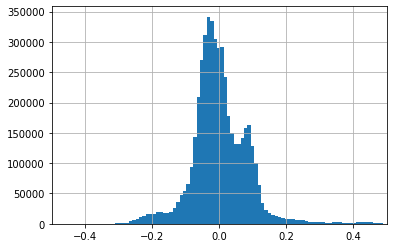

In [104]:
sfm_fpd_tls['diff_sfm_tls'].hist(bins=200)
plt.xlim(-0.5,0.5)
plt.savefig(f'{dataDir}/diff_hist.svg')

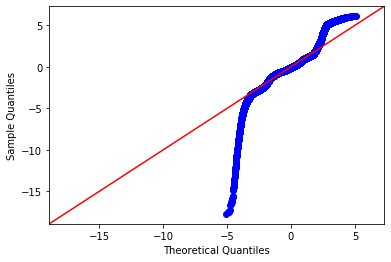

In [105]:
# QQ plot
qqplot(sfm_fpd_tls['diff_sfm_tls'],fit=True,line='45');

In [106]:
# Shapiro-Wilk normality test
stat, p = ss.shapiro(sfm_fpd_tls['diff_sfm_tls'])
print(f'Statistics={stat:.3f}, p={p:.3f}')
# interpret
alpha = 0.05
if p > alpha:
    print('Sample looks Gaussian (fail to reject H0)')
else:
    print('Sample does not look Gaussian (reject H0)')

Statistics=0.937, p=0.000
Sample does not look Gaussian (reject H0)


/Users/guano/.pyenv/versions/3.7.4/lib/python3.7/site-packages/scipy/stats/morestats.py:1676: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


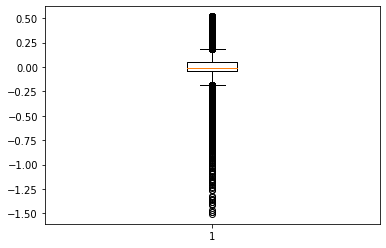

In [107]:
# boxplot 
bp = plt.boxplot(sfm_fpd_tls['diff_sfm_tls'])
plt.savefig(f'{dataDir}/diff_boxplot.svg')

<br>
<div style="text-align: right"><a href="#top">back to top</a></div>

### Correlation (all pixels)

In [108]:
# TLS x interpolated SfM DEM
y = sfm_fpd_tls['tls']
x = sfm_fpd_tls['sfm']
slope, intercept, r_value, p_value, std_err = linregress(x, y)

# line_y = slope * x + intercept
# sfm_tls.plot.scatter(x='sfm',y='tls',c='diff',colormap='bwr')
# plt.plot(x, line_y, color="red") 
# plt.savefig(f'{dataDir}/corrplot.svg')

print (f'slope = {slope:.4f}')
print (f'intercept = {intercept:.4f}')
print (f'r_value = {r_value:.4f}') # correlation coefficient
print (f'r_squared = {r_value**2:.4f}') # coefficient of determination
print (f'p_value = {p_value:.4f}')
print (f'std_err = {std_err:.4f}')

slope = 0.9980
intercept = 0.0476
r_value = 0.9999
r_squared = 0.9998
p_value = 0.0000
std_err = 0.0000


<br>
<div style="text-align: right"><a href="#top">back to top</a></div>

### MAE, RMSE (all pixels)

In [109]:
rmse_tls_sfm = err_rmse(sfm_fpd_tls['tls'],sfm_fpd_tls['sfm'])
mae_tls_sfm = err_mae(sfm_fpd_tls['tls'],sfm_fpd_tls['sfm'])

print (f'RMSE TLS x SfM: {rmse_tls_sfm:.3f}')
print (f'MAE TLS x SfM: {mae_tls_sfm:.3f}')

RMSE TLS x SfM: 0.085
MAE TLS x SfM: 0.061


In [110]:
rmse_tls_sfm = err_rmse(sfm_fpd_tls['tls'],sfm_fpd_tls['fpd'])
mae_tls_sfm = err_mae(sfm_fpd_tls['tls'],sfm_fpd_tls['fpd'])

print (f'RMSE TLS x SfM FPD: {rmse_tls_sfm:.3f}')
print (f'MAE TLS x SfM FPD: {mae_tls_sfm:.3f}')

RMSE TLS x SfM FPD: 0.085
MAE TLS x SfM FPD: 0.061


<br>
<div style="text-align: right"><a href="#top">back to top</a></div>

### Stats - random selection within dataframe

In [111]:
# select 200 values from dataframe
sfm_fpd_tls_rand = sfm_fpd_tls.sample(2000, random_state=123456)

In [112]:
# calculate stats for each DEM
# could've used pd.describe() but I wanted skew and kurtosis
# also, I wanted the table with stats as columns
df_stats = pd.DataFrame(columns = ['min','max','mean','median','stddev','skew','kurt','p25','p75'], index=['tls','sfm','fpd'])
for dem in ['tls','sfm','fpd','diff_sfm_tls','diff_fpd_tls']:
    rast_max = sfm_fpd_tls_rand[dem].max()
    rast_min = sfm_fpd_tls_rand[dem].min()
    rast_mean = sfm_fpd_tls_rand[dem].mean()
    rast_median = sfm_fpd_tls_rand[dem].quantile(q=0.50)
    rast_stddev = sfm_fpd_tls_rand[dem].std()
    rast_p25 = sfm_fpd_tls_rand[dem].quantile(q=0.25)
    rast_p75 = sfm_fpd_tls_rand[dem].quantile(q=0.75)
    rast_skew = sfm_fpd_tls_rand[dem].skew()
    rast_kurt = sfm_fpd_tls_rand[dem].kurtosis()
    df_stats.loc[dem] = [rast_min,rast_max,rast_mean,rast_median,rast_stddev,rast_skew,rast_kurt,rast_p25,rast_p75]

df_stats

min    max   mean median stddev   skew   kurt    p25    p75
tls           8.526 36.023 24.015 24.840  6.455 -0.277 -0.725 18.863 28.639
sfm           8.483 35.990 24.010 24.830  6.468 -0.281 -0.730 18.822 28.654
fpd           8.477 35.989 24.010 24.826  6.468 -0.281 -0.729 18.824 28.654
diff_sfm_tls -0.338  0.434 -0.004 -0.012  0.084  0.344  3.172 -0.048  0.041
diff_fpd_tls -0.344  0.429 -0.004 -0.012  0.084  0.344  3.186 -0.048  0.042

In [113]:
# print(df_stats.to_latex(float_format="{:4.3f}".format))
# \begin{tabular}{llllllllll}
# \toprule
# {} &    min &    max &   mean & median & stddev &   skew &   kurt &    p25 &    p75 \\
# \midrule
# tls          &  8.526 & 36.023 & 24.015 & 24.840 &  6.455 & -0.277 & -0.725 & 18.863 & 28.639 \\
# sfm          &  8.483 & 35.990 & 24.010 & 24.830 &  6.468 & -0.281 & -0.730 & 18.822 & 28.654 \\
# fpd          &  8.477 & 35.989 & 24.010 & 24.826 &  6.468 & -0.281 & -0.729 & 18.824 & 28.654 \\
# diff\_sfm\_tls & -0.338 &  0.434 & -0.004 & -0.012 &  0.084 &  0.344 &  3.172 & -0.048 &  0.041 \\
# diff\_fpd\_tls & -0.344 &  0.429 & -0.004 & -0.012 &  0.084 &  0.344 &  3.186 & -0.048 &  0.042 \\
# \bottomrule
# \end{tabular}

In [114]:
# how much of the TLS DEM is below the SfM one?
ss.percentileofscore(tuple(sfm_fpd_tls_rand['diff_sfm_tls']),0)

56.45

<br>
<div style="text-align: right"><a href="#top">back to top</a></div>

### Graphics, errors (2000 pixels)

In [115]:
# histogram of differences (SfM minus TLS)
# FDR rule
print ('bins for diff: {:d}'.format(fdr(sfm_fpd_tls_rand['diff_sfm_tls'])))
# print (f'bins for diff: {fdr(sfm_tls['diff']):d}')

bins for diff: 54


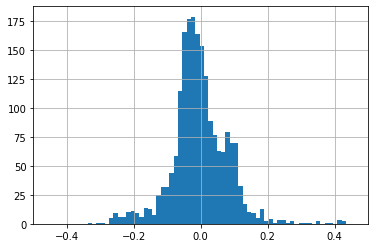

In [116]:
sfm_fpd_tls_rand['diff_sfm_tls'].hist(bins=60)
plt.xlim(-0.5,0.5)
plt.savefig(f'{dataDir}/diff_hist_rand.svg')

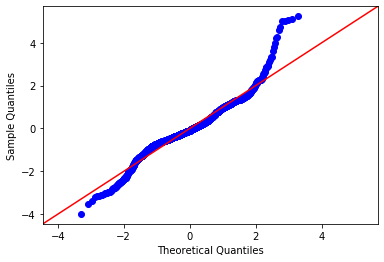

In [117]:
# QQ plot
qqplot(sfm_fpd_tls_rand['diff_sfm_tls'],fit=True,line='45');

In [118]:
# Shapiro-Wilk normality test
stat, p = ss.shapiro(sfm_fpd_tls_rand['diff_sfm_tls'])
print(f'Statistics={stat:.3f}, p={p:.3f}')
# interpret
alpha = 0.05
if p > alpha:
    print('Sample looks Gaussian (fail to reject H0)')
else:
    print('Sample does not look Gaussian (reject H0)')

Statistics=0.954, p=0.000
Sample does not look Gaussian (reject H0)


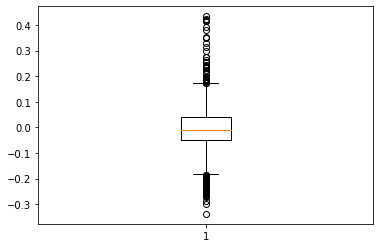

In [119]:
# boxplot 
bp = plt.boxplot(sfm_fpd_tls_rand['diff_sfm_tls'])
plt.savefig(f'{dataDir}/diff_boxplot_rand.svg')

In [120]:
# number of outliers
len(bp['fliers'][0]._y)

102

In [121]:
# whiskers y_val
[item.get_ydata()[1] for item in bp['whiskers']]

[-0.18203375254299203, 0.17420957653028069]

<br>
<div style="text-align: right"><a href="#top">back to top</a></div>

### Correlation (2000 pixels)

slope = 0.9980
intercept = 0.0520
r_value = 0.9999
r_squared = 0.9998
p_value = 0.0000
std_err = 0.0003


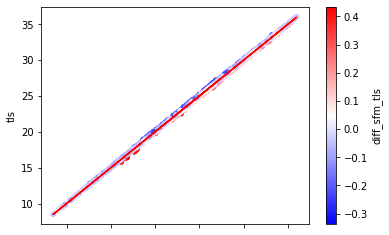

In [122]:
# TLS x interpolated SfM DEM
y = sfm_fpd_tls_rand['tls']
x = sfm_fpd_tls_rand['sfm']
slope, intercept, r_value, p_value, std_err = linregress(x, y)

line_y = slope * x + intercept
sfm_fpd_tls_rand.plot.scatter(x='sfm',y='tls',c='diff_sfm_tls',colormap='bwr')
plt.plot(x, line_y, color="red") 
plt.savefig(f'{dataDir}/corrplot_rand.svg')

print (f'slope = {slope:.4f}')
print (f'intercept = {intercept:.4f}')
print (f'r_value = {r_value:.4f}') # correlation coefficient
print (f'r_squared = {r_value**2:.4f}') # coefficient of determination
print (f'p_value = {p_value:.4f}')
print (f'std_err = {std_err:.4f}')

<br>
<div style="text-align: right"><a href="#top">back to top</a></div>

### MAE, RMSE (2000 pixels)

In [123]:
rmse_tls_sfm = err_rmse(sfm_fpd_tls_rand['tls'],sfm_fpd_tls_rand['sfm'])
mae_tls_sfm = err_mae(sfm_fpd_tls_rand['tls'],sfm_fpd_tls_rand['sfm'])

print (f'RMSE TLS x SfM: {rmse_tls_sfm:.3f}')
print (f'MAE TLS x SfM: {mae_tls_sfm:.3f}')

RMSE TLS x SfM: 0.084
MAE TLS x SfM: 0.061


In [124]:
rmse_tls_sfm = err_rmse(sfm_fpd_tls_rand['tls'],sfm_fpd_tls_rand['fpd'])
mae_tls_sfm = err_mae(sfm_fpd_tls_rand['tls'],sfm_fpd_tls_rand['fpd'])

print (f'RMSE TLS x SfM FPD: {rmse_tls_sfm:.3f}')
print (f'MAE TLS x SfM FPD: {mae_tls_sfm:.3f}')

RMSE TLS x SfM FPD: 0.084
MAE TLS x SfM FPD: 0.061


<br><br><br><br><br><br>
<div style="text-align: right"><a href="#top">back to top</a></div>

## Comparison between Airborne LiDAR / SfM-MVS

### Interpolate ALS and SfM DEMs, create shaded relief images

In [125]:
# settings for interpolation, shaded reliefs, name the files, set mask
method='bilinear'
step = 2
altitude = 30
azimuth = 25
az_txt = f'{azimuth:>03.0f}'

dem_als = f'als_50cm_{method}_step_{str(step)}'
dem_als_shade = f'{dem_als}_shade_{az_txt}_{str(altitude)}'

dem_sfm = f'sfm_50cm_{method}_step_{str(step)}'
dem_sfm_shade = f'{dem_sfm}_shade_{az_txt}_{str(altitude)}'

diff_sfm_als = 'diff_sfm_minus_als'
dem_diff_shade = f'{diff_sfm_als}_shade_{az_txt}_{str(altitude)}'

# set region (0.5m resolution 3D) and mask 
n = 6900951.5
s = 6899231.5
w = 731859.0
e = 732783.5
grass.run_command('g.region', n=n,s=s,w=w,e=e,t=60,b=0, res3=0.5, flags='p3a', save='dunes_default', overwrite=ow)
grass.run_command('r.mask', vector=mask_sfm, overwrite=ow)
# grass.run_command('r.mask', flags='r')

In [126]:
# Interpolate ALS 
grass.run_command('v.surf.bspline', input=pc_als, raster_output=dem_als, ew_step=step, ns_step=step, method=method, mask='MASK', overwrite=ow)

In [127]:
# Interpolate SfM 
grass.run_command('v.surf.bspline', input=pc_sfm_t125, raster_output=dem_sfm, ew_step=step, ns_step=step, method=method, mask='MASK', overwrite=ow)

In [128]:
# DEM of Difference - ALS (2010) minus SfM (2019)
grass.mapcalc('${out} = ${sfm} - ${als}',
    out=diff_sfm_als,
    als=dem_als,
    sfm=dem_sfm,
    overwrite = True)

In [129]:
# make shaded reliefs and optionally export as tiff
# ALS
grass.run_command('r.relief', input=dem_als, output=dem_als_shade, azimuth=azimuth, altitude=altitude, overwrite=ow)
# grass.run_command('r.out.gdal', input=dem_als_shade, output=dem_als_shade+'.tif', format='GTiff', type='Int16')
# SfM
grass.run_command('r.relief', input=dem_sfm, output=dem_sfm_shade, azimuth=azimuth, altitude=altitude, overwrite=ow)
# grass.run_command('r.out.gdal', input=dem_sfm_shade, output=dem_sfm_shade+'.tif', format='GTiff', type='Int16')
# diff
grass.run_command('r.colors', map=diff_sfm_als, color='differences')
grass.run_command('r.relief', input=diff_sfm_als, output=dem_diff_shade, azimuth=azimuth, altitude=altitude, overwrite=ow)
# grass.run_command('r.out.gdal', input=dem_diff_shade, output=dem_diff_shade+'.tif', format='GTiff', type='Int16')

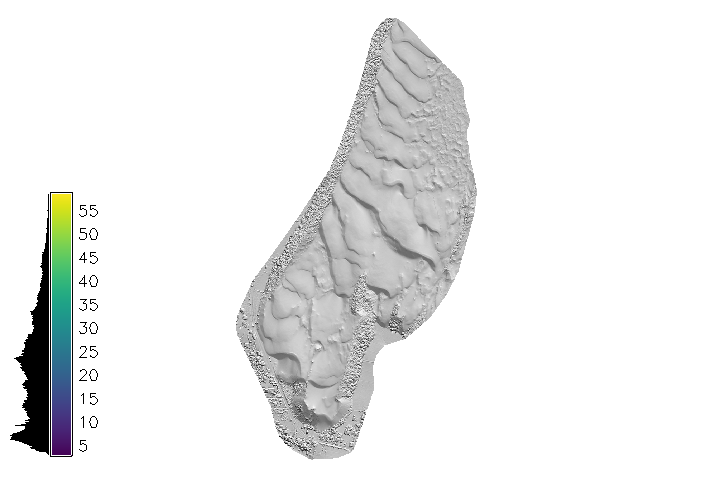

In [130]:
# display with virtual monitor rendered to png
grass.run_command('d.mon', start='png', output='view.png', overwrite=ow)
grass.run_command('d.rast', map=dem_als_shade)
grass.run_command('d.legend', raster=dem_als, at='5,60,7,10', range='0,60', flags='sd', label_step=5)
Image('view.png') 

In [131]:
grass.run_command('d.mon', stop='png') 

<br>
<div style="text-align: right"><a href="#top">back to top</a></div>

### Stats, histograms

In [132]:
# files names
als_tif = f'{dataDir}/{dem_als}.tif'
sfm_tif = f'{dataDir}/{dem_sfm}.tif'

In [133]:
# export to dataDir
grass.run_command('r.out.gdal', input=dem_als, output=als_tif, format='GTiff', overwrite=ow)
grass.run_command('r.out.gdal', input=dem_sfm, output=sfm_tif, format='GTiff', overwrite=ow)

In [134]:
# read into dataframe
df_dems = pd.DataFrame()

sfm = xr.open_rasterio(sfm_tif)
df_dems['sfm'] = sfm.to_series().dropna()

als = xr.open_rasterio(als_tif)
df_dems['als'] = als.to_series().dropna()

In [135]:
# diff col
df_dems['dod'] = df_dems['sfm'] - df_dems['als']

In [136]:
# option - use numpy to read DEM from GRASS (requires aux func, but not xarray)
# read DSMs as arrays and create dataframe
# df_dems = pd.DataFrame()
# df_dems['als'] = raster_as_array(dem_als)
# df_dems['sfm'] = raster_as_array(dem_sfm)
# df_dems['dod'] = raster_as_array(diff_sfm_als)

In [137]:
# calculate stats for each DEM
# could've used pd.describe() but I wanted skew and kurtosis as well
df_stats = pd.DataFrame(columns = ['min','max','mean','median','stddev','skew','kurt','p25','p75'], index=['als','sfm','dod'])
for dem in ['als','sfm','dod']:
    rast_max = df_dems[dem].max()
    rast_min = df_dems[dem].min()
    rast_mean = df_dems[dem].mean()
    rast_median = df_dems[dem].quantile(q=0.50)
    rast_stddev = df_dems[dem].std()
    rast_p25 = df_dems[dem].quantile(q=0.25)
    rast_p75 = df_dems[dem].quantile(q=0.75)
    rast_skew = df_dems[dem].skew()
    rast_kurt = df_dems[dem].kurtosis()
    df_stats.loc[dem] = [rast_min,rast_max,rast_mean,rast_median,rast_stddev,rast_skew,rast_kurt,rast_p25,rast_p75]

df_stats

min    max   mean median stddev  skew   kurt    p25    p75
als   2.691 58.883 21.336 20.649 11.593 0.506 -0.411 11.644 28.769
sfm   2.888 58.625 21.643 20.668 11.659 0.447 -0.574 11.635 29.397
dod -16.950 23.153  0.307  0.392  3.476 0.156  2.772 -1.259  1.799

In [138]:
# # export stats to latex
# print(df_stats.to_latex(float_format="{:4.2f}".format))
# \begin{tabular}{llllllllll}
# \toprule
# {} &    min &   max &  mean & median & stddev & skew &  kurt &   p25 &   p75 \\
# \midrule
# als &   2.69 & 58.88 & 21.34 &  20.65 &  11.59 & 0.51 & -0.41 & 11.64 & 28.77 \\
# sfm &   2.89 & 58.63 & 21.64 &  20.67 &  11.66 & 0.45 & -0.57 & 11.63 & 29.40 \\
# dod & -16.95 & 23.15 &  0.31 &   0.39 &   3.48 & 0.16 &  2.77 & -1.26 &  1.80 \\
# \bottomrule
# \end{tabular}

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1cb9af790>,
      dtype=object)

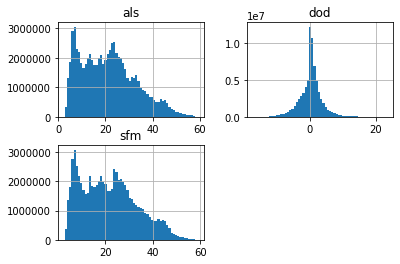

In [139]:
# quick histograms, bins=60 as this is the approx range of elevation
df_dems.hist(bins=60)

In [140]:
# use Freedman–Diaconis rule to calculate optimal bin size? -- TOO MUCH
print (f'bins for ALS: {fdr(df_dems.als):d}')
print (f'bins for SfM: {fdr(df_dems.sfm):d}')
print (f'bins for DoD: {fdr(df_dems.dod):d}')

bins for ALS: 689
bins for SfM: 658
bins for DoD: 2753


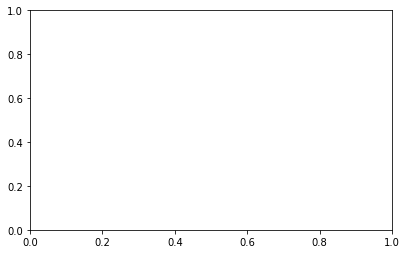

In [141]:
# make individual histograms and save as svg (in dataDir)
def do_hist(dem,nbins,out_dir):
    '''make histograms, save as svg in out_dir'''
    fileOut = f'{dataDir}/hist_{dem}.svg'
    df_dems[dem].hist(bins=nbins, label=dem)
    plt.title('Elevation histogram, '+ dem)
    plt.xlabel('Elevation')
    plt.ylabel('Cell count')
    plt.legend()
    plt.tight_layout()
    plt.savefig(fileOut)
    plt.clf()
    plt.cla()
    
# will use same number of bins for ALS and SfM
figDir = '.'
do_hist('als',nbins=60,out_dir=figDir)
do_hist('sfm',nbins=60,out_dir=figDir)
do_hist('dod',nbins=40,out_dir=figDir)
# an empty plot will be displayed, not sure why

<br>
<div style="text-align: right"><a href="#top">back to top</a></div>

### Volume calculation with r.volume and r3.stats

In [142]:
mask_vol = 'mask_vol'
grass.run_command('g.region', vector=mask_vol, res=0.5, tbres=0.1, flags='pa3')

#### ALS LiDAR

In [143]:
# make raster of mask_vol
grass.run_command('v.to.rast', input=mask_vol, output=mask_vol, use='val', overwrite=True)

In [144]:
# r.volume
# here we use the 'mask_vol' raster as a clump raster to sum the volume of each cell
als_rvol_txt = grass.read_command('r.volume', input=dem_als, clump=mask_vol)

# print(als_rvol_txt)

# Volume report on data from <als_50cm_bilinear_step_2> using clumps on <mask_vol> raster map

# Category   Average   Data   # Cells        Centroid             Total
# Number     in clump  Total  in clump   Easting     Northing     Volume
# -----------------------------------------------------------------------------
#        1     24.08  36140462 1500908   732324.75  6900039.25       9035115.45
# -----------------------------------------------------------------------------
#                                                 Total Volume =     9035115.45

#### SfM DEM

In [145]:
# r.volume
sfm_rvol_txt = grass.read_command('r.volume',input=dem_sfm, clump=mask_vol)

# print (sfm_rvol_txt)

# Volume report on data from <sfm_50cm_bilinear_step_2> using clumps on <mask_vol> raster map

# Category   Average   Data   # Cells        Centroid             Total
# Number     in clump  Total  in clump   Easting     Northing     Volume
# -----------------------------------------------------------------------------
#        1     24.01  36043380 1500908   732324.75  6900039.25       9010844.95
# -----------------------------------------------------------------------------
#                                                 Total Volume =     9010844.95

In [146]:
# difference
diff_rvol = grass.read_command('r.volume',input=diff_sfm_als, clump=mask_vol)

# print(diff_rvol)

# Volume report on data from <diff_sfm_minus_als> using clumps on <mask_vol> raster map

# Category   Average   Data   # Cells        Centroid             Total
# Number     in clump  Total  in clump   Easting     Northing     Volume
# -----------------------------------------------------------------------------
#        1     -0.06    -97082 1500908   732324.75  6900039.25        -24270.50

In [147]:
100-9010844.95*100/9035115.45

0.2686241269888825

<br>
<div style="text-align: right"><a href="#top">back to top</a></div>

### Displacement of dune crests

#### first calculate surface roughness of ALS and SfM DEMs

In [148]:
# settings for roughness, names for the files
w = 5  # window size
op = 'stddev' # neighborhood operation

als_slope = f'{dem_als}_slope'
sfm_slope = f'{dem_sfm}_slope'

als_rough = f'{als_slope}_std_{w}x{w}'
sfm_rough = f'{sfm_slope}_std_{w}x{w}'

In [149]:
# slope
grass.run_command('r.slope.aspect', elevation=dem_als, slope=als_slope, overwrite=ow)
grass.run_command('r.slope.aspect', elevation=dem_sfm, slope=sfm_slope, overwrite=ow)

In [150]:
# roughness
grass.run_command('r.neighbors', input=als_slope, output=als_rough, method=op, size=w, overwrite=ow)
grass.run_command('r.neighbors', input=sfm_slope, output=sfm_rough, method=op, size=w, overwrite=ow)

In [151]:
# set custom colortable, based on viridis
rules='''0 255:255:255
1 253:231:37
3 93:201:98
5 32:144:141
7 58:82:139
9 68:1:84
13 155:0:0
30 155:0:0
'''
# save rules to file
with open('rules.txt', 'w+') as file:
    file.write(rules)

grass.run_command('r.colors', map=als_rough, rules='rules.txt')
grass.run_command('r.colors', map=sfm_rough, rules='rules.txt')

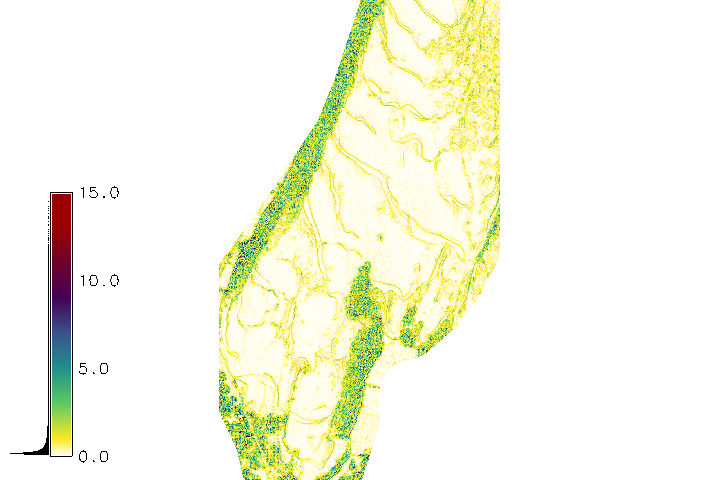

In [152]:
# display with virtual monitor rendered to png
grass.run_command('d.mon', start='png', output='view.png', overwrite=ow)
grass.run_command('d.rast', map=als_rough)
grass.run_command('d.legend', raster=als_rough, at='5,60,7,10', range='0,15', flags='sd', label_step=5)
Image('view.png') 

In [153]:
grass.run_command('d.mon', stop='png') 

In [154]:
# show detail of roughness map with dune crest

In [155]:
# import crests shapefiles
shp_crests_als = f'{dataDir}/crests_als_2010.shp'
als_crests = 'crests_als_2010'

shp_crests_sfm = f'{dataDir}/crests_sfm_2019.shp'
sfm_crests = 'crests_sfm_2019'

In [156]:
grass.run_command('v.in.ogr', input=shp_crests_als, output=als_crests, flags='o', overwrite=ow)
grass.run_command('v.in.ogr', input=shp_crests_sfm, output=sfm_crests, flags='o', overwrite=ow)

In [157]:
# set region
n = 6900380
s = 6900160
w = 732290
e = 732550
grass.run_command('g.region', n=n,s=s,w=w,e=e)

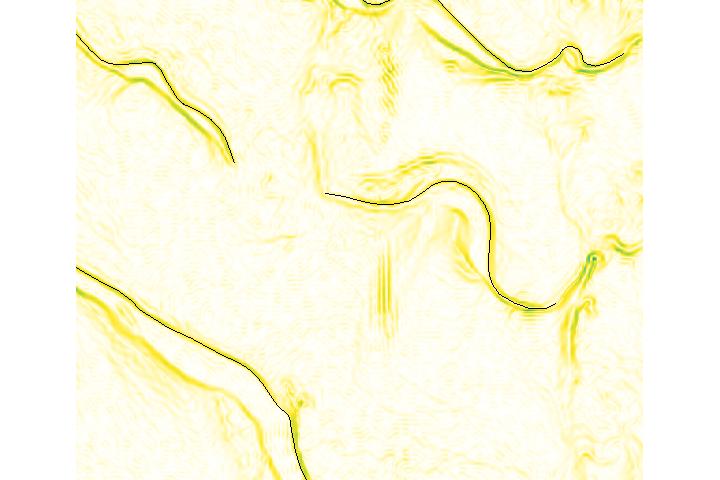

In [158]:
# display with virtual monitor rendered to png
grass.run_command('d.mon', start='png', output='view.png', overwrite=ow)
grass.run_command('d.rast', map=als_rough)
grass.run_command('d.vect', map=als_crests, color='black')
# grass.run_command('d.legend', raster=als_rough, at='5,60,7,10', range='0,15', flags='sd', label_step=5)
Image('view.png') 

In [159]:
grass.run_command('d.mon', stop='png') 

#### displacement of crests

In [160]:
# displacement lines file
shp_lin = f'{dataDir}/displacement_crests_2010_2019.shp'

In [162]:
# azimuth and length are calculated by functions in 'azim_p3.py'
azim, leng = azim_p3.azim(shp_lin)

Linear features in file: 164

len azimuth: 164


In [163]:
# put azim, length in dataframe
df_lin = pd.DataFrame(columns=['az','len'])

In [164]:
df_lin['az'] = azim
df_lin['len'] = leng

In [165]:
df_lin.describe()    

az     len
count 164.000 164.000
mean   77.134  44.337
std    71.472  16.624
min    28.301   6.590
25%    36.812  32.311
50%    38.973  44.780
75%    48.272  53.506
max   223.285  84.346

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x276adb210>,
      dtype=object)

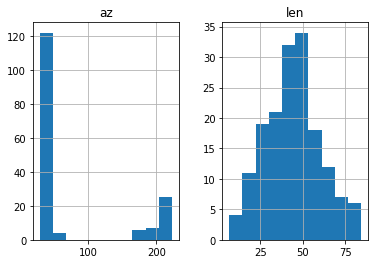

In [166]:
df_lin.hist()

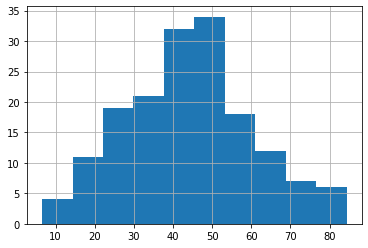

In [167]:
# nbins with Freedman–Diaconis rule
nbins = fdr(df_lin['len'])
df_lin['len'].hist(bins=nbins)

In [168]:
# Normality tests for displacement length
# https://machinelearningmastery.com/a-gentle-introduction-to-normality-tests-in-python/

In [169]:
data = df_lin['len']

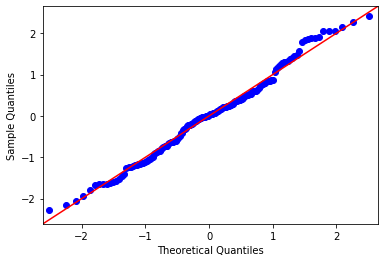

In [170]:
# QQ plot
qqplot(data,fit=True,line='45');

In [171]:
# Shapiro-Wilk Test
# from scipy.stats import shapiro
# normality test
stat, p = ss.shapiro(data)
print(f'Statistics={stat:.3f}, p={p:.3f}')
# interpret
alpha = 0.05
if p > alpha:
	print('Sample looks Gaussian (fail to reject H0)')
else:
	print('Sample does not look Gaussian (reject H0)')

Statistics=0.988, p=0.153
Sample looks Gaussian (fail to reject H0)


In [172]:
# D’Agostino’s K^2 Test
# from scipy.stats import normaltest
stat, p = ss.normaltest(data)
print(f'Statistics={stat:.3f}, p={p:.3f}')
# interpret
alpha = 0.05
if p > alpha:
	print('Sample looks Gaussian (fail to reject H0)')
else:
	print('Sample does not look Gaussian (reject H0)')

Statistics=1.055, p=0.590
Sample looks Gaussian (fail to reject H0)


In [173]:
# Anderson-Darling Test
# from scipy.stats import anderson
# normality test
result = ss.anderson(data)
print(f'Statistic: {result.statistic:.3f}')
p = 0
for i in range(len(result.critical_values)):
	sl, cv = result.significance_level[i], result.critical_values[i]
	if result.statistic < result.critical_values[i]:
		print(f'{sl:.3f}: {cv:.3f}, data looks normal (fail to reject H0)')
	else:
		print(f'{sl:.3f}: {cv:.3f}, data does not look normal (reject H0)')

Statistic: 0.554
15.000: 0.563, data looks normal (fail to reject H0)
10.000: 0.641, data looks normal (fail to reject H0)
5.000: 0.769, data looks normal (fail to reject H0)
2.500: 0.897, data looks normal (fail to reject H0)
1.000: 1.067, data looks normal (fail to reject H0)


In [174]:
# from scipy.stats import kstest
ss.kstest(data, 'lognorm', args=(1,))

KstestResult(statistic=0.9780098475326018, pvalue=2.6696937324149005e-272)

<br>
<div style="text-align: right"><a href="#top">back to top</a></div>

### Azimuth analysis

In [175]:
# Looking at the histogram, we see that the azimuth 
# of displacement lines are clustered in the NE and SW quadrants.
# Since azimuth is calculated from the endpoints of lines, 
# we get both quadrants depending on how teh line was drawn. 
# The dune field migrates southward, so we need to convert
# the azimuth values to south quadrants (SE, SW)
azimMod = [] 
for az in df_lin['az']:
    if 0.0 < az <= 90.0: # NE quadrant
        azimMod.append(az + 180.0)
    elif 270.0 <= az <= 360.0: # NW quadrant
        azimMod.append(az + 180.0)
    else:
        azimMod.append(az)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x276c85610>]],
      dtype=object)

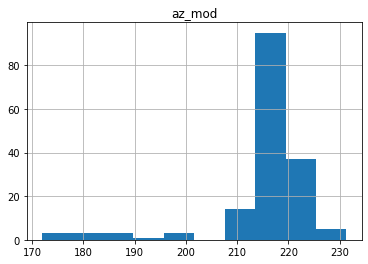

In [176]:
# make a dataframe just to plot the histogram easily
az_m = pd.DataFrame(azimMod, columns =['az_mod']) 
az_m.hist()

In [177]:
# calculate mean direction
# from Fisher 1993, Statistical Analyis of circular data, p.31
az_rad = np.deg2rad(azimMod)
sinTheta = np.sin(az_rad)
cosTheta = np.cos(az_rad)
C = np.sum(cosTheta)
S = np.sum(sinTheta)

ThetaBar = np.arctan2(C,S)
ThetaBarDeg = np.rad2deg(ThetaBar)

In [178]:
# convert from arctan2 degrees to azimuth 
# (note: modulo 360 does not work for this)
# https://stackoverflow.com/a/25398191/4984000
if ThetaBarDeg > 90.0:
    ThetaBarDeg = 450.0 - ThetaBarDeg
else:
    ThetaBarDeg = 90.0 - ThetaBarDeg

In [179]:
# mean direction of dune displacement
ThetaBarDeg

215.55194503485

<br>
<div style="text-align: right"><a href="#top">back to top</a></div>

### Topographic profiles

In [180]:
coords=(732000,6899600,732470,6900445)

In [183]:
grass.run_command('g.region', region='dunes_default', overwrite=ow)

In [184]:
# ALS
p_als = grass.read_command('r.profile', input=dem_als , output='-', coordinates=coords, res=0.5, null='*') 
p_als_x = p_als.split()[0::2]
p_als_y = p_als.split()[1::2]
als_x=[float(num) for num in p_als_x]
als_y=[float(num) for num in p_als_y]

In [185]:
# SfM
p_sfm = grass.read_command('r.profile', input=dem_sfm , output='-', coordinates=coords, res=0.5, null='*') 
p_sfm_x = p_sfm.split()[0::2]
p_sfm_y = p_sfm.split()[1::2]
sfm_x=[float(num) for num in p_sfm_x]
sfm_y=[float(num) for num in p_sfm_y]

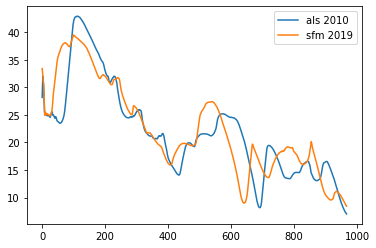

In [186]:
# plot
plt.plot(als_x,als_y,label='als 2010')
plt.plot(sfm_x,sfm_y,label='sfm 2019')
plt.legend()
# save svg
fig = f'{dataDir}/topo_profiles_als_sfm.svg'
plt.savefig(fig)

In [187]:
# end GRASS GIS session
os.remove(rcfile)

<br>
<div style="text-align: right"><a href="#top">back to top</a></div>